In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use(['seaborn-ticks', 'seaborn-talk'])
import seaborn as sns
import cartopy.crs as ccrs
import cmocean

import logging
logging.basicConfig(level=logging.WARNING)

import xarray as xr
import pandas as pd
import numpy as np

import air_quality as aq
from air_quality.plot import usa_states_ax

import warnings; warnings.simplefilter('ignore')

/Users/daniel/anaconda/lib/python3.5/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In this notebook, I want to try out different improvements to the model-fitting algorithm which might lead to simplified/improved code and the possibility to extend the model in underlying statistical model in the future.

# Linear Model - Feature Selection

One of the issues I have with the current formulation of Lu Shen's models is that he uses a Monte Carlo approach to figure out which components to retain in the model for each grid cell. I think this is very prone to over-fitting; his "stopping criterion" is based on the correlation coefficient of the resulting models applied to each held-out sample in his cross-validation. But this really isn't defensible; each of those models has a (potentially) different underlying SVD mode set depending on the meteorology used in the training years, so it's not quite an apples-to-apples comparison. It's also slow, and dramatically increases the overhead of the calculation - not all variable parameter combinations should be tested since we know temperature and the synoptic modes are far more important than the others.

A far better approach would be to use an objective stopping criterion or searching approach to iteratively construct the "best" feature set. Cross-validate on that; then you have an issue of what happens if you have different models in your end cross-validation folds, but there's probably a way to break ties and figure out which model components to retain.

Here, I'm going to play with using [scikit-learn's feature selection tools](http://scikit-learn.org/stable/modules/feature_selection.html) to automate this process. I'll take one grid cell of data, pre-fit SVD modes based on all the data, then select the features. Once that's working, I'll add in the cross-validation.

## Data Prep

To begin, let's load up our existing data and begin the process of fitting our model to it. We ultimately want the data for just one timeseries.

In [125]:
from air_quality.models.shen2017 import Shen2017Model

grid_stack = ['lat', 'lon']
cell_name = 'cell'
predictand = 'PM25'
predictors = ['TEMP', 'RH', 'PRECIP', 'U', 'V']
dilon, dilat = 6, 4
# dilon, dilat = 3, 2

data = xr.open_dataset("../data/obs.usa_subset.nc")


mask = np.isnan(data.PRECIP.isel(time=0)).rename("CONUS_MASK")

month = 6
model = Shen2017Model(
    data,
    month=month, verbose=True, n_predictors=3, cross_validate=True,
    lat_range=(30, 35), lon_range=(-85, -80), 
    mask=mask
)

<xarray.Dataset>
Dimensions:  (lat: 12, lon: 24)
Coordinates:
  * lat      (lat) float32 22.5 25.0 27.5 30.0 32.5 35.0 37.5 40.0 42.5 45.0 ...
  * lon      (lon) float32 -125.0 -122.5 -120.0 -117.5 -115.0 -112.5 -110.0 ...
Data variables:
    RH       (lat, lon) float64 79.7 79.15 78.64 79.87 79.87 81.09 85.74 ...
    U        (lat, lon) float64 -3.196 -1.917 -0.6792 0.7292 1.779 3.067 ...
    TEMP     (lat, lon) float64 18.12 17.92 17.88 18.63 18.75 18.48 20.64 ...
    V        (lat, lon) float64 -5.321 -5.671 -5.929 -6.2 -5.679 -3.75 ...
    PRECIP   (lat, lon) float32 nan nan nan nan nan nan nan nan nan nan nan ...
    PM25     (lat, lon) float32 nan nan nan nan nan nan nan nan nan nan nan ...
<xarray.Dataset>
Dimensions:  (lat: 12, lon: 24)
Coordinates:
  * lat      (lat) float32 22.5 25.0 27.5 30.0 32.5 35.0 37.5 40.0 42.5 45.0 ...
  * lon      (lon) float32 -125.0 -122.5 -120.0 -117.5 -115.0 -112.5 -110.0 ...
Data variables:
    RH       (lat, lon) float64 80.87 80.31 79.55 81.78

In [126]:
model.fit_parallel()
for gcr, gcf in model._gcr_gcf_iter:
    if gcr is None:
        continue
    print(gcf, gcr)
    result = gcr.result
    print(result.params.index)
    print("--"*40)

Loop over all grid cells:  80%|███████▉  | 229/288 [00:09<00:02, 22.90it/s]]

KeyboardInterrupt: 

Extract data for Georgia.

In [103]:
from air_quality.models.shen2017 import GridCellFactor, sites

# Select the grid cell for Georgia
def find_nearest(array, value):
    idx = (np.abs(array-value)).argmin(dtype='int')
    return idx

site = sites['Georgia']
ilon = int(find_nearest(data.lon, site.lon))
ilat = int(find_nearest(data.lat, site.lat))
print(site)
print(ilon, ilat)

# Set up a GridCellFactor so we know what swath to extract
gcf = GridCellFactor(ilon, ilat, model.dilon, model.dilat)

field_data = model._data_detrend_normalize.isel(
    lat=gcf.ilat_range, lon=gcf.ilon_range
)
local_data = model._data_detrend_normalize.isel(lon=ilon, lat=ilat)

y_ref = local_data[model.predictand].copy()
x_ref = (
    field_data.stack(**{model.cell_name: model.grid_stack})
    .transpose(model.cell_name, 'time')
)

# Fit and project our SVD modes
pt_corrs, svd_modes = model._fit_svd_modes(x_ref, y_ref)
Sks_ds = model._project_svd_modes(field_data, svd_modes)
modes = []
for i in range(5):
    mode = 'S_{:d}'.format(i+1)
    local_data[mode] = Sks_ds[mode]
    modes.append(mode)
    
# Prep the data for fitting
local_df = (
    local_data#.sel(time=times_train)
    .squeeze()
    .to_dataframe()
    .reset_index()
    .loc[:, model.predictors + modes + [model.predictand, ]]
)

Site(name='Georgia', lon=-82.5, lat=32.5)
17 4


As a sanity check, let's visualize the correlation matrix for our data and some timeseries.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1221375f8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x122607668>], dtype=object)

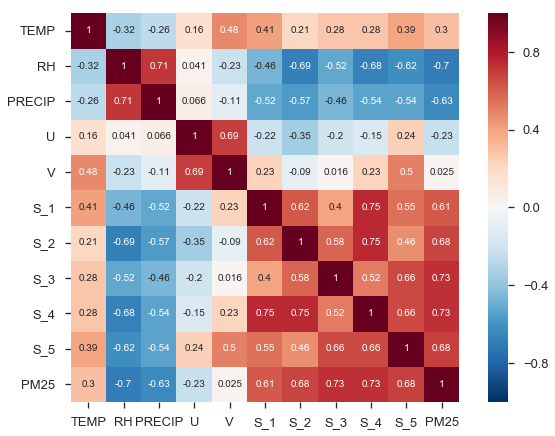

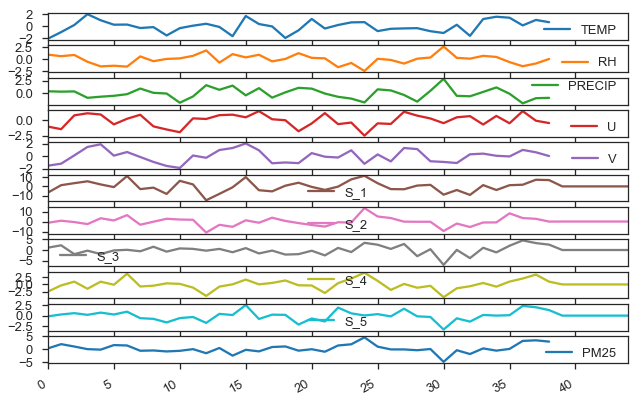

In [40]:
corrmat = local_df.corr()
sns.heatmap(corrmat, annot=True, square=True)

local_df.plot(subplots=True)

## Fit Linear Model

Fitting a linear regression via scikit-learn is easy; we simply us the [LinearRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) estimator. A notable difference from using statsmodels is that we don't actually use our data labels; we need to split off our **X** and **y** data as arrays. Each column in **X** is one of our linear predictors. We need to be extra careful to clean up data that is missing or else the estimator will fail.

In [95]:
from sklearn.linear_model import LinearRegression

_to_model = local_df.dropna()
print(len(local_df), len(_to_model))

X_df = _to_model[model.predictors + modes]
X = X_df.values
y_df = _to_model[[model.predictand, ]]
y = y_df.values
print(X.shape, y.shape)

lm = LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=-1)
# lm.fit(X, y)
# print(lm.score(X, y))

45 39
(39, 10) (39, 1)


### `SelectFromModel`

In [93]:
from sklearn.feature_selection import SelectFromModel

mm = SelectFromModel(lm, prefit=True)
# mm.fit(X, y)
support = mm.get_support()
print(X_df.columns[support])
X_new = mm.transform(X)
X_new.shape

Index(['RH', 'V', 'S_3', 'S_4', 'S_5'], dtype='object')


(39, 5)

### `RFE`

In [119]:
from sklearn.feature_selection import RFE

mm = RFE(estimator=lm, n_features_to_select=3, step=1, verbose=1)
mm = mm.fit(X, y)

support = mm.support_
print(support)
print(mm.ranking_)
print(X_df.columns[support])

Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
[False  True False False  True False False False False  True]
[5 1 4 7 1 8 6 3 2 1]
Index(['RH', 'V', 'S_5'], dtype='object')


### `RFECV` + custom cross-validator

In [172]:
from sklearn.feature_selection import RFECV
from sklearn.metrics import explained_variance_score, mean_absolute_error, r2_score 
from functools import partial

class OmitYear:
    def __init__(self, n, width=3, offset=0):
        self.n = n
        self.width = width
        self.offset = offset  # TODO: Implement me!
    def __iter__(self):
        inds = list(range(self.n))
        inds_set = set(inds)
        for i in range(self.n // self.width):
            test = inds[(i*self.width):(i*self.width)+self.width]
            train = list(inds_set - set(test))
            yield train, test
# cv = list(test_cv(X, y))
cv = OmitYear(len(y), width=3, offset=0)

def my_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    return explained_variance_score(y, y_pred)


lm = LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=-1)
mm = RFECV(estimator=lm, step=1, cv=cv, scoring=my_scorer)
mm.fit(X, y)

RFECV(cv=<__main__.OmitYear object at 0x121666e10>,
   estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False),
   n_jobs=1, scoring=<function my_scorer at 0x1227b1bf8>, step=1,
   verbose=0)

In [173]:
print(mm.grid_scores_)
print(mm.support_)
print(mm.n_features_)

[-2.0601903  -2.64438419 -2.40796068 -3.30361029 -2.67129859 -2.64251967
 -3.05641167 -3.14278746 -3.11884999 -3.36867649]
[False  True False False False False False False False False]
1


Compare with our previously fitted model

In [221]:
for gcr, gcf in model._gcr_gcf_iter:
    if gcr is None:
        continue
    if (gcf.ilon == ilon) and (gcf.ilat == ilat):
        print(gcf, gcr)
        result = gcr.result
        print(result.params.index)
        break


Iterate over grid cell models:   0%|          | 0/288 [00:00<?, ?it/s]

GridCellFactor - [17, 4] GridCellResult - PM25 ~ TEMP + RH + PRECIP + U + V (r^2=0.000613428 | MSE=2.82848)
Index(['Intercept', 'V'], dtype='object')


In [225]:
rsq = np.array(gcr.all_rs)**2
for cand, rr in zip(gcr.all_candidates, rsq):
    print(cand, rr)

['TEMP'] 0.000239499793425
['RH'] 0.366492517446
['PRECIP'] 0.266603674528
['U'] 0.0285184085365
['V'] 0.566064062591
['S_1'] 0.0791221037623
['S_2'] 0.263065252435
['TEMP' 'RH'] 0.332311969705
['TEMP' 'PRECIP'] 0.246691291274
['TEMP' 'U'] 0.0122999515928
['TEMP' 'V'] 5.48287760784e-05
['TEMP' 'S_1'] 0.0698794702112
['TEMP' 'S_2'] 0.261947632403
['RH' 'PRECIP'] 0.379707010099
['RH' 'U'] 0.382970741403
['RH' 'V'] 0.352950042062
['RH' 'S_1'] 0.339795353476
['RH' 'S_2'] 0.410879911996
['PRECIP' 'U'] 0.224009177586
['PRECIP' 'V'] 0.198379025714
['PRECIP' 'S_1'] 0.218346739561
['PRECIP' 'S_2'] 0.348710521683
['U' 'V'] 4.91634017751e-05
['U' 'S_1'] 0.0816070247206
['U' 'S_2'] 0.257611063335
['V' 'S_1'] 0.0847286038168
['V' 'S_2'] 0.252080672705
['S_1' 'S_2'] 0.155954912025
['TEMP' 'RH' 'PRECIP'] 0.347009040986
['TEMP' 'RH' 'U'] 0.367045462427
['TEMP' 'RH' 'V'] 0.358655243945
['TEMP' 'RH' 'S_1'] 0.300562071522
['TEMP' 'RH' 'S_2'] 0.378763879187
['TEMP' 'PRECIP' 'U'] 0.23153807914
['TEMP' 'PRE

### Monte Carlo

The problem here is pretty clear; none of these methods actually do what we want them to do.

In [180]:
from air_quality.models.shen2017 import _all_combos

# Monte Carlo
predictors = list(X_df.columns)
combos = list(_all_combos(predictors, len(predictors)))
lms = []
for combo in combos:
    Xc = _to_model[list(combo)].values
    lm = LinearRegression().fit(Xc, y)
    lms.append(lm)

In [200]:
# Iterative
potential_predictors = predictors.copy()
ordered = []
all_scores = []
ordered_scores = []
while potential_predictors:
    pool = potential_predictors.copy()
    scores = []
    for trial_predictor in pool:
        trial_predictors = ordered + [trial_predictor, ]
        
        Xc = _to_model[trial_predictors].values
        lm = LinearRegression().fit(Xc, y)
        scores.append(lm.score(Xc, y))
    
    scores, pool = zip(*sorted(zip(scores, pool)))
    ordered.append(pool[-1])
    all_scores.append(scores)
    ordered_scores.append(scores[-1])
    
    potential_predictors.remove(pool[-1])

(0.0, 1.0)

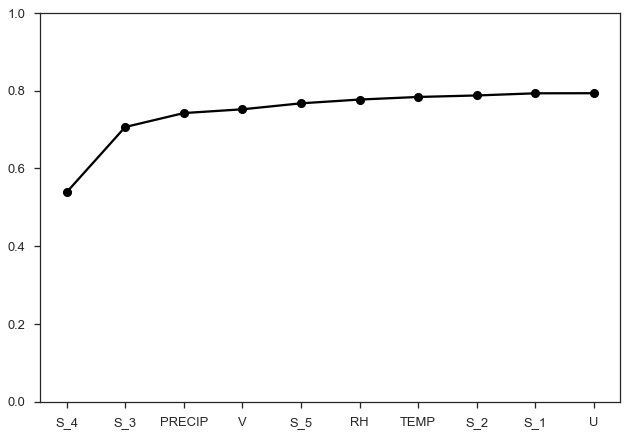

In [202]:
plt.plot(ordered_scores, '-ok')
locs, labels = plt.xticks()
plt.xticks(range(len(ordered)), ordered)
plt.ylim(0., 1.)

---

## Summary

This experiment wasn't terribly successful. There are issues with how to evaluate a fitted model that complicate the choice of algorithm to perform the feature selection, especially when it comes to how those features are iteratively chosen. I still think a Monte Carlo approach, like what Lu Shen does, is going to over-fit the model in some cases and severely underfit it in others. An iterative approach would be far more defensible, and we have the flexibility to record different sized models in different grid cells.

---

# `Pipeline` Implementation

I implemented the core algorithm which fits the model from Shen et al (2017) in a very straightforward, logical way within `Shen2017Model`. That class really has two components though: 

1. An encapsulation or wrapper of many fitted models at each grid cell; and
2. The actual model fitting

The actual model fitting is nearly 200 LOC, but that's partly because I have to implement two completely separate methods: one for the actual fitting, and a specialized cross-validation to mimic what Shen did in his original paper. The cross-validation is *significantly* more complicated and longer than the basic model fitting because we have to retain information about each fit for the vector of models from the LOO CV strategy, then re-construct a final, entirely new model at the very end.

The entire process of fitting the model at an individual grid cell involves the following steps:

1. **Pre-processing**
  - Sub-sample timesteps by only choosing the month of interest and its two surrounding months
  - Sub-sample geography by choosing a halo region surrounding the cell of interest
2. De-trend the sub-sampled data
3. Normalize the *predictor* features 
4. Fit the SVD mode decomposition and use it to generate the SVD timeseries
5. Fit all the potential OLS models using up to *n* predictors

Now, an sklearn `Pipeline` should be xarray-friendly if it is constructed from Transformers which are such. So if we adapt our code/components from before into such a format, then we should theoretically be able to construct a `Pipeline` which entirely operates on our xarray-encoded data.

Finally, we can build a custom cross-validation strategy (really it's a grid search) to perform Shen's LOO method to evaluate the model fits. This problem means re-ordering his looping strategy. His outer loop goes over every year individually, and then his inner loop tries every single regression features candidate; this is all saved in a 2D array with shape (*n* years x 3, *m* candidates). What is actually saved is the model prediction; these are evaluted for each *m* candidate versus the observed predictands to figure out the best model.

There is a package called [xlearn](https://github.com/wy2136/xlearn) which has some rudimentary implementation of some of these ideas.

--- 

We start by reading in data for our analysis.

In [4]:
import xarray as xr
import numpy as np
from air_quality.models.shen2017 import Shen2017Model

grid_stack = ['lat', 'lon']
cell_name = 'cell'
predictand = 'PM25'
predictors = ['TEMP', 'RH', 'PRECIP', 'U', 'V']
dilon, dilat = 6, 4

data = xr.open_dataset("../data/obs.usa_subset.nc")

mask = np.isnan(data.PRECIP.isel(time=0)).rename("CONUS_MASK")

month = 6
model = Shen2017Model(
    data,
    month=month, verbose=True, n_predictors=3, cross_validate=False,
    lat_range=(30, 35), lon_range=(-85, -80), 
    mask=mask
)

In [3]:
model.fit_parallel()
for gcr, gcf in model._gcr_gcf_iter:
    if gcr is None:
        continue
    print(gcf, gcr)
    result = gcr.result
    print(result.params.index)
    print("--"*40)
    break

Iterate over grid cell models:   0%|          | 0/288 [00:00<?, ?it/s]

GridCellFactor - [16, 3] GridCellResult - PM25 ~ TEMP + RH + PRECIP + U + V (r^2=0.620408 | MSE=3.98112)
Index(['Intercept', 'RH', 'PRECIP', 'S_1'], dtype='object')
--------------------------------------------------------------------------------


In the following cell we'll collect the transformers that we create.

In [5]:
from sklearn.base import TransformerMixin
from sklearn.preprocessing import FunctionTransformer, StandardScaler, RobustScaler, Imputer
from sklearn.pipeline import FeatureUnion
from functools import reduce

from air_quality.models.shen2017 import _months_surrounding, _isin, _detrend_moving_avg

class NoFitMixin(object):
    
    def fit(self, X, y=None):
        return self

class Reshaper(object):
    
    def __init__(self, dims_to_stack=['lat', 'lon'], stacked_name='cell'):
        self.dims_to_stack = dims_to_stack
        self.stacked_name = stacked_name
        
    def stack(self, ds):
        stacked = ds.stack(**{self.stacked_name: self.dims_to_stack})
        # Move stacked dim to front
        return stacked.T

    def unstack(self, ds):
        return ds.unstack(self.stacked_name)
rs = Reshaper()
_ds = rs.stack(data)

class DatasetFeatureUnion(FeatureUnion):
    """ FeatureUnion for xarray Datasets """
    
    def __init__(self, transformer_list, **kwargs):
        self.transformer_list = transformer_list
        super().__init__(transformer_list, **kwargs)
        
    def fit(self, X, y=None):
        for (name, t) in self.transformer_list:
            t.fit(X, y)
        return self
    
    def fit_transform(self, X, y=None):
        if y is None:
            return self.fit(X).transform(X)
        else:
            return self.fit(X, y).transform(X)
    
    
    def transform(self, X):
        # Assumes X is a Dataset
        Xts = [t.transform(X) for _, t in self.transformer_list]
        Xunion = reduce(lambda X1, X2: xr.merge([X1, X2]), Xts)
        return Xunion    
    

class FieldExtractor(TransformerMixin, NoFitMixin):
    def __init__(self, fields):
        self.fields = fields
    
    def transform(self, X):
        return X[self.fields]
    
class MonthSelector(TransformerMixin, NoFitMixin):
    
    def __init__(self, month, dim='time'):
        self.month = month
        self.dim = dim
        self._months = _months_surrounding(self.month)
    
    def transform(self, X):
        idx = _isin(X['{}.month'.format(self.dim)], self._months)
        return X.sel(**{self.dim: idx})
    
# ms = MonthSelector(6)
# ms.fit_transform(_ds)

class DatasetSelector(TransformerMixin, NoFitMixin):
    def __init__(self, sel='sel', **indexers):
        self.sel = sel
        self.indexers = indexers
        
    def transform(self, X, **kwargs):
        if self.sel == 'sel':
            return X.sel(**self.indexers)
        else:
            return X.isel(**self.indexers)
    
class Normalizer(TransformerMixin):
    
    def __init__(self, copy=True, with_mean=True, with_std=True, dim='time'):
        self.dim = dim
        self.copy = copy
        self.with_mean = with_mean
        self.with_std = True
        self.mean_ = None
        self.scale_ = None
        
    def fit(self, X, Y=None, **kwargs):
        if self.with_mean:
            self.mean_ = X.mean(self.dim, skipna=True)
        if self.with_std:
            self.scale_ = X.std(self.dim, skipna=True)
        return self
    
    def transform(self, X, **kwargs):
        if self.copy:
            X = X.copy()
        if self.with_mean:
            X -= self.mean_
        if self.with_std:
            X /= self.scale_
        return X
    
    def inverse_transform(self, X, copy=None):
        copy = copy if copy is not None else self.copy
        if copy:
            X = X.copy()
        if self.with_std:
            X *= self.scale_
        if self.with_mean:
            X += self.mean_
        return X
        
# nm = Normalizer()
# res = nm.fit_transform(_ds)
# _ds2 = nm.inverse_transform(res)

class Stacker(TransformerMixin, NoFitMixin):
    
    def __init__(self, dims_to_stack=['lat', 'lon'], stacked_name='cell'):
        self.dims_to_stack = dims_to_stack
        self.stacked_name = stacked_name
    
    def transform(self, X):
        stacked = X.stack(**{self.stacked_name: self.dims_to_stack})
        # Move stacked dim to front
        return stacked.T

    def inverse_transform(self, X):
        return X.unstack(self.stacked_name)

class YearlyMovingAverageDetrender(TransformerMixin):

    def __init__(self, dim='time', with_mean=False, n_years=5, center=True, min_periods=1, copy=True):
        self.dim = dim
        self.with_mean = with_mean
        self.n_years = n_years
        self.center = center
        self.min_periods = min_periods
        self.copy = copy
        
        self.moving_avg_trend_ = None
        
    def fit(self, X, y=None, **kwargs):
        Xg = X.groupby('time.month')
        if self.with_mean:
            # We have to include the mean here as an offset so it gets computed for each
            # monthly timeseries of annual values
            self.moving_avg_trend_ = Xg.apply(
                lambda x: x.rolling(center=self.center, min_periods=self.min_periods,
                                    **{self.dim: self.n_years}).mean() - x.mean(self.dim, skipna=True)
            )
        else:
            self.moving_avg_trend_ = Xg.apply(
                lambda x: x.rolling(center=self.center, min_periods=self.min_periods,
                                    **{self.dim: self.n_years}).mean()
            )
            
        return self
    
    def transform(self, X, **kwargs):
        # Xg = X.groupby('time.month')
        X_detrend = X - self.moving_avg_trend_
        return X_detrend.dropna(self.dim, how='all')
# dt = YearlyMovingAverageDetrender(with_mean=True)
# detr = dt.fit_transform(_ds)


class DatasetFunctionTransformer(TransformerMixin, NoFitMixin):
    """ FunctionTransformer but for xarray Datasets """
    
    def __init__(self, func, copy=False):
        self.func = func
        self.copy = copy
    
    def transform(self, X):
        _X = X if not self.copy else X.copy()
        return _X.apply(self.func)

Test plot for detrender

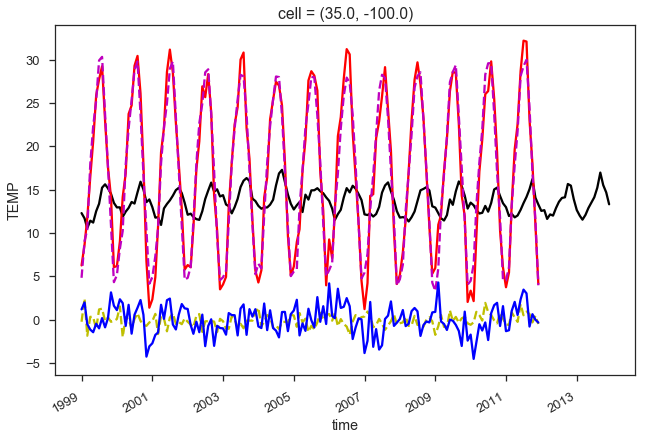

In [6]:
_ds.isel(cell=144)['TEMP'].plot(color='k')

dt = YearlyMovingAverageDetrender(with_mean=True, n_years=5)
dt.fit(_ds)
dt.moving_avg_trend_.isel(cell=130)['TEMP'].plot(color='y', ls='dashed')
dt.transform(_ds).isel(cell=130)['TEMP'].plot(color='r')

dt = YearlyMovingAverageDetrender(with_mean=False, n_years=5)
dt.fit(_ds)
dt.moving_avg_trend_.isel(cell=130)['TEMP'].plot(color='m', ls='dashed')
dt.transform(_ds).isel(cell=130)['TEMP'].plot(color='b')

Illustrate how we can chain the extraction/preprocessing very trivially with a `Pipeline`:

In [8]:
from sklearn.pipeline import Pipeline, make_pipeline

pipeline = Pipeline([
    ('predictands', FieldExtractor(predictors)),
    ('subset_time', MonthSelector(6)),
    ('detrend', YearlyMovingAverageDetrender()),
    ('normalize', Normalizer())
])
X_ds = pipeline.fit_transform(data)

pipeline = Pipeline([
    ('predictands', FieldExtractor([predictand, ])),
    ('subset_time', MonthSelector(6)),
    ('subset_latlon', DatasetSelector(sel='isel', lon=12, lat=6)),
    ('detrend', YearlyMovingAverageDetrender()),
])
y_ds = pipeline.fit_transform(data)

local_ds = DatasetSelector(sel='isel', lon=12, lat=6).fit_transform(X_ds)

So we will use these to prep our `X` and `y` data. The next challenge is to encode our SVD in this framework.


In [9]:
from air_quality.models.shen2017 import _calc_correlations, _calc_svd, stack_fields

class SVDModeCompressor(TransformerMixin):
    
    def __init__(self, predictors=predictors, predictand=None, max_modes=2):
        self.predictors = predictors
        self.predictand = predictand
        self.max_modes = max_modes
        
        self.F = None
        self.u, self.v, self.evr = None, None, None
        
    def fit(self, X, y=None):
        
        # Compute field correlations
        if self.predictand:
            yf = y[self.predictand].values
        else:
            yf = y.copy()
        field_rs = []
        for field in self.predictors:
            xf = X[field].values
            rs, ps = _calc_correlations(yf, xf)
            field_rs.append(rs)
            # self.pt_corrs[field + '_r'] = ([self.cell_name, ], rs)
            # self.pt_corrs[field + '_p'] = ([self.cell_name, ], ps)
            
        # Create SVD modes
        # self.F = stack_fields(self.pt_corrs, 
        #                       fields=[p+"_r" for p in self.predictors], 
        #                       reshape=False)
        self.F = np.stack([rs for rs in field_rs], axis=-1)
        self.F[np.isnan(self.F)] = 0.
        self.u, self.v, self.evr = _calc_svd(self.F)
        
        # Some legacy code archiving which part of the SVD decomp is what
        # svd_modes = pt_corrs.copy().drop([p+"_r" for p in self.predictors] +
        #                                  [p+"_p" for p in self.predictors])
        # svd_modes['field'] = (['field', ], self.predictors)
        # svd_modes['mode'] = (['mode', ], range(1, len(self.predictors)+1))
        # svd_modes['svd_weights'] = (['cell', 'mode'], u)
        # svd_modes['var_weights'] = (['mode', 'field'], v)
        # svd_modes['explained_variance'] = (['mode', ], evr)
        
        return self
    
    def transform(self, X):
        
        Sks = []
        for ti in range(len(X.time)):
            # Compute M matrix
            _ds = X.isel(time=ti)
            M = stack_fields(_ds, self.predictors, reshape=False)
            
            Ski = np.inner(np.dot(self.u.T, M), self.v).diagonal()
            Sks.append(Ski)
        Sks = np.asarray(Sks)
        
        # Convert to a Dataset
        Sks_ds = X.copy().drop(self.predictors)
        Sis = []
        for i in range(1, self.max_modes+1):
            Si = 'S_{:d}'.format(i)
            Sks_ds[Si] = (['time', ], Sks[:, i-1])
            Sis.append(Si)
        Sks_ds = Sks_ds[Sis]
        
        return Sks_ds        
        
X = X_ds.copy()
y = y_ds.copy()#.isel(lon=12, lat=6)

ss = SVDModeCompressor()
rs = Reshaper()
X2 = rs.stack(X)
ss.fit(X2, y['PM25'])

## Sanity Check - SVD Results

In [10]:
res = ss.transform(X2)

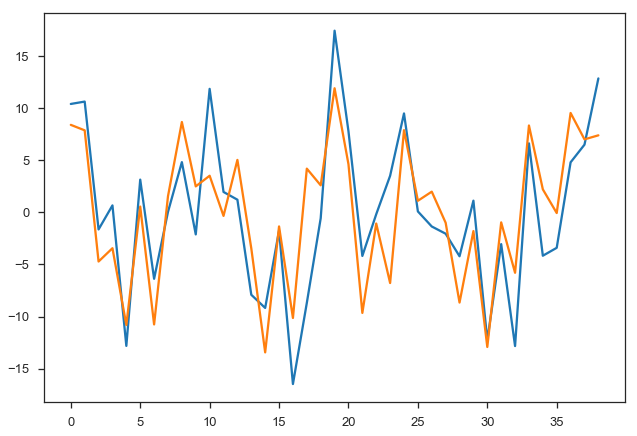

In [11]:
plt.plot(res.to_dataframe().values)

In [12]:
pt_corrs = X2.copy().drop(predictors + ['time', ])
for i, field in enumerate(predictors):
    rsi = ss.F[:, i]
    pt_corrs[field + '_r'] = (['cell', ], rsi)
pt_corrs = pt_corrs.unstack('cell')

svd_modes = X2.copy().drop(predictors + ['time', ])
svd_modes['field'] = (['field', ], predictors)
svd_modes['mode'] = (['mode', ], range(1, len(predictors)+1))
svd_modes['svd_weights'] = (['cell', 'mode'], ss.u)
svd_modes['var_weights'] = (['mode', 'field'], ss.v)
svd_modes['explained_variance'] = (['mode', ], ss.evr)

svd_modes = svd_modes.unstack('cell')

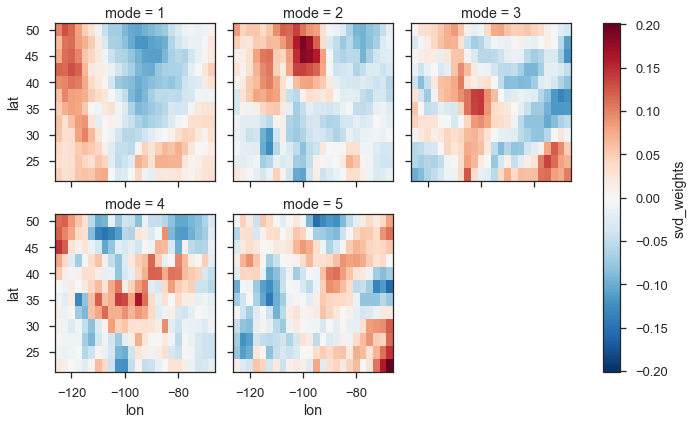

In [13]:
svd_modes['svd_weights'].plot.imshow('lon', 'lat', col='mode', col_wrap=3)

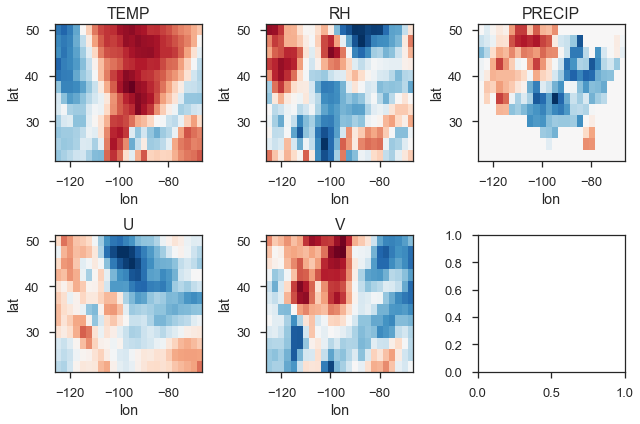

In [14]:
from darpy.plot import get_figsize

nrows, ncols = 2, 3
size, aspect = 3., 1.
figsize = get_figsize(nrows, ncols, size, aspect)
fig, axs = plt.subplots(nrows, ncols, figsize=figsize)

for ax, field in zip(axs.ravel(), predictors):
    pt_corrs['{}_r'.format(field)].plot.imshow('lon', 'lat', ax=ax, add_colorbar=False)
    ax.set_title(field)
plt.tight_layout()

## Merge into `Pipeline`

In [15]:
from air_quality.models.shen2017 import GridCellFactor
from sklearn.pipeline import Pipeline

ilon, ilat = 18, 8
gcf = GridCellFactor(ilon, ilat, dilon=4, dilat=3)

pp = Pipeline([
    ('predictand', FieldExtractor([predictand, ])),
    ('subset_time', MonthSelector(6)),
    ('subset_latlon', DatasetSelector(sel='isel', lon=gcf.ilon, lat=gcf.ilat)),
    ('detrend', YearlyMovingAverageDetrender()),
])
y_ds = pp.fit_transform(data)

local_pipeline = Pipeline([
    ('predictors', FieldExtractor(predictors)),
    ('subset_time', MonthSelector(6)),
    ('detrend', YearlyMovingAverageDetrender()),
    ('normalize', Normalizer()),
    ('subset_latlon', DatasetSelector(sel='isel', lon=gcf.ilon, lat=gcf.ilat)),
])
hybrid_pipeline = Pipeline([
    ('predictors', FieldExtractor(predictors)),
    ('subset_time', MonthSelector(6)),
    ('detrend', YearlyMovingAverageDetrender()),
    ('subset_latlon', DatasetSelector(sel='isel', 
                                      lon=gcf.ilon_range, lat=gcf.ilat_range)),
    ('normalize', Normalizer()),
    ('stack', Stacker(['lon', 'lat'], 'cell')),
    ('svd_modes', SVDModeCompressor(predictors, predictand))
])

features = DatasetFeatureUnion([
    ('local', local_pipeline),
    ('hybrid', hybrid_pipeline),
])
to_model = features.fit_transform(data, y_ds)

## Linear Regression

In [16]:
_include = predictors + ['S_1', 'S_2'] # + ['S_3', 'S_4', 'S_5']
X = to_model.drop(['lon', 'lat']).to_dataframe()[_include].values
y = y_ds[predictand].values

In [17]:
from sklearn.linear_model import LinearRegression

lin = LinearRegression()
lin.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

r2 = 0.850799843117


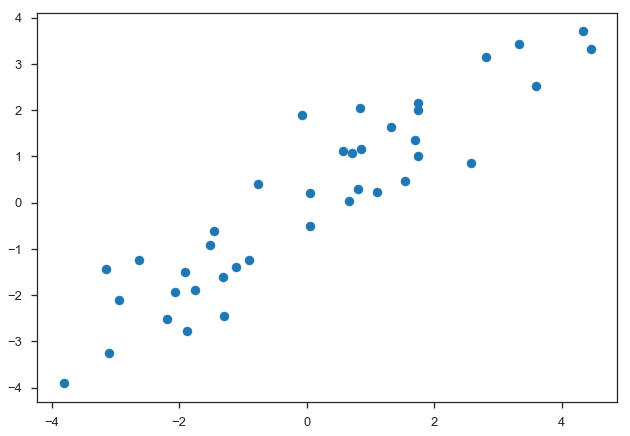

In [18]:
yp = lin.predict(X)
plt.scatter(y, yp)
plt.plot()
print("r2 =", lin.score(X, y))

In [19]:
from sklearn.feature_selection import RFE, RFECV

mm = RFE(estimator=lin, n_features_to_select=3, step=1, verbose=1)
mm = mm.fit(X, y)

support = mm.support_
print(support)
print(mm.ranking_)
print(np.asarray(_include)[support])

Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
[ True  True  True False False False False]
[1 1 1 4 2 5 3]
['TEMP' 'RH' 'PRECIP']


## Cross-validate 

Now we want to cross-validate by leaving one year of data out at a time. We can write a [custom cross-validator generator](http://fa.bianp.net/blog/2015/holdout-cross-validation-generator/) to act on our Datasets and accomplish this.

In [18]:
from sklearn.model_selection import BaseCrossValidator

class NaiveYearlyLeaveOneOut(BaseCrossValidator):

    def __init__(self, n=3):
        self.n = 3

    def _iter_test_indices(self, X, y=None, groups=None):
        inds = np.arange(self.n)
        for i in range(len(X) // self.n):
            yield inds + self.n*i
            
    def get_n_splits(self, X, y=None, groups=None):
        return len(X) / self.n
        

In [19]:
cv = NaiveYearlyLeaveOneOut()
for train, test in cv.split(X, y):
    print(test)

[0 1 2]
[3 4 5]
[6 7 8]
[ 9 10 11]
[12 13 14]
[15 16 17]
[18 19 20]
[21 22 23]
[24 25 26]
[27 28 29]
[30 31 32]
[33 34 35]
[36 37 38]


In [20]:
from sklearn.model_selection import cross_val_predict

lin = LinearRegression()
n = 3
groups = np.unique(to_model.time.dt.year).repeat(n)
y_pred = cross_val_predict(lin, X, y, groups=groups, cv=NaiveYearlyLeaveOneOut(n),
                           verbose=1)

[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.0s finished


In [21]:
y_pred

array([ 1.17123487,  1.32726203,  3.47192911,  0.1620488 , -1.23010113,
       -3.14771388,  1.19590015,  0.08164535, -0.81103945, -2.10431788,
        2.03137128,  3.05642115, -1.53988709, -2.59693009, -1.40508718,
        2.02557943, -2.00260362, -1.92693698, -1.35371716,  3.59688894,
        2.1942367 ,  0.05158092, -0.09512373,  0.50027225,  3.22030662,
        1.06917021, -0.52910892, -2.89684621,  0.78507433,  0.49847633,
       -1.79892206, -2.64507544, -4.04341838,  2.13716102,  1.32682473,
        1.85056609, -0.87867719,  0.19099925,  2.20305832])

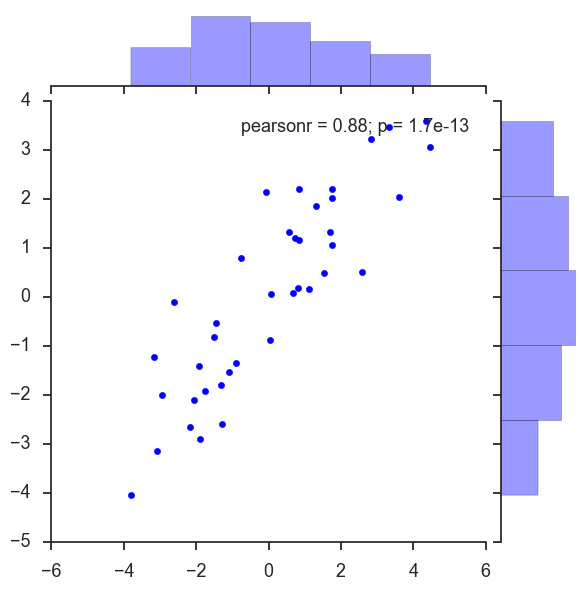

In [22]:
sns.jointplot(y, y_pred)

Finally, let's try to combine the feature selection with the cross-vaidation using `RFECV`.

In [23]:
from sklearn.feature_selection import RFECV

mm = RFECV(estimator=lin, step=1, verbose=0, cv=NaiveYearlyLeaveOneOut(3))
mm = mm.fit(X, y)

support = mm.support_
print(support)
print(mm.ranking_)
print(np.asarray(_include)[support])

[ True False False False False False False]
[1 3 2 6 4 7 5]
['TEMP']


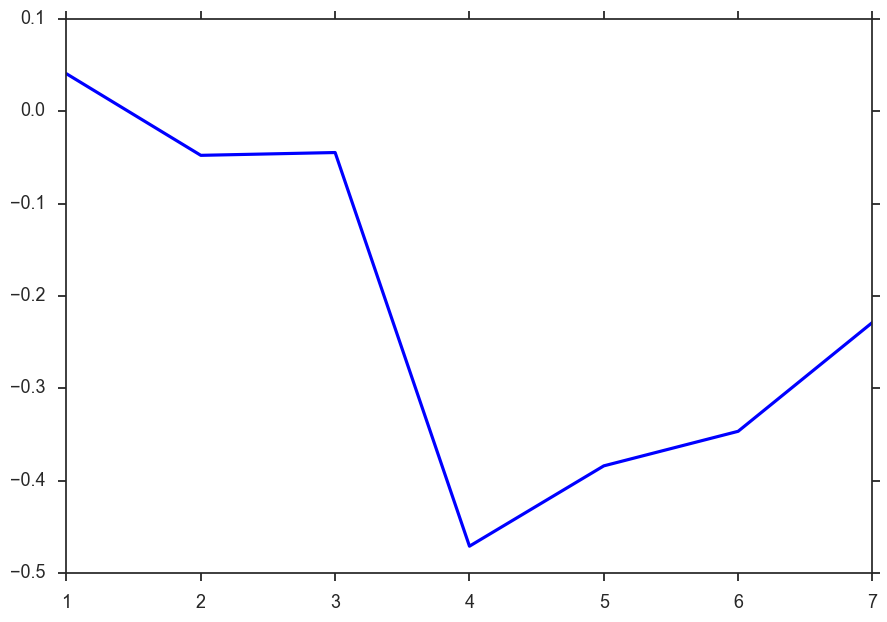

In [24]:
plt.plot(range(1, len(mm.grid_scores_) + 1), mm.grid_scores_)

## Custom Feature Selection

We now want to implement our previous logic to check the performance of all the combinations of features.

In [25]:
from sklearn.feature_selection.base import SelectorMixin
from sklearn.base import BaseEstimator, clone
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from joblib import Parallel, delayed
from tqdm import tqdm

from itertools import chain, combinations

estimator = LinearRegression()
cv = NaiveYearlyLeaveOneOut(3)
n_features = 3
verbose = 0

_X = X.copy()
_y = y.copy()

n_obs, n_feat = _X.shape

all_combos = list(chain(*[combinations(list(range(n_feat)), i)
                          for i in range(1, 1 + n_features)]))

scores = []
for feat_inds in tqdm(all_combos):

    _estimator = clone(estimator)
    if verbose > 0:
        print("Fitting estimator with features {}".format(feat_inds))

    y_pred = cross_val_predict(_estimator, _X[:, feat_inds], _y, 
                               cv=cv, verbose=verbose)

    score = r2_score(_y, y_pred)
    # score = pearsonr(_y, y_pred)[0]**2
    # estimator.fit(X[:, feat_inds], y)
    scores.append(score)
    
# Recover the best model
idx = np.argmax(scores)
features = list(all_combos[idx])
support = np.asarray([False, ]*n_feat)
support[features] = True

_estimator = clone(estimator)
_estimator.fit(_X[:, support], _y)

print(np.asarray(_include)[support])

    # Get coefs
#     if hasattr(estimator, 'coef_'):
#         coefs = estimator.coef_
#     else:
#         coefs = getattr(estimator, 'feature_importances_', None)
#     if coefs is None:
#         raise RuntimeError('The classifier does not expose '
#                            '"coef_" or "feature_importances_" '
#                            'attributes')

100%|██████████| 63/63 [00:01<00:00, 61.06it/s]

['TEMP' 'RH' 'S_1']


In [26]:
yp = _estimator.predict(_X[:, support])

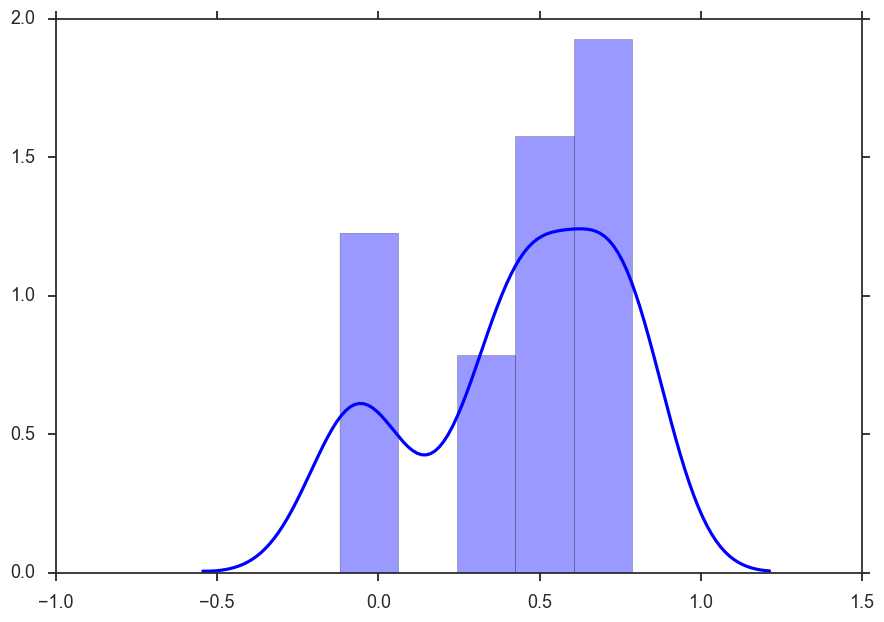

In [27]:
sns.distplot(scores)

(-6.0, 6.0)

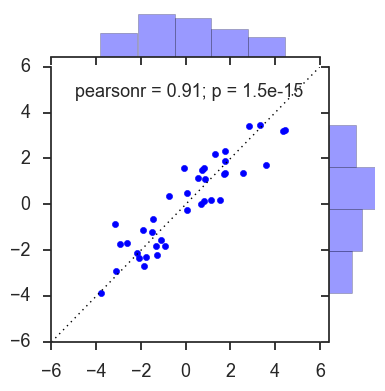

In [28]:
jg = sns.jointplot(_y, yp, size=4)
xlo, xhi = jg.ax_joint.get_xlim()
ylo, yhi = jg.ax_joint.get_ylim()
lo, hi = np.min([xlo, ylo]), np.max([xhi, yhi])
jg.ax_joint.plot([lo, hi], [lo, hi], color='k', lw=1., ls='dotted')
jg.ax_joint.set_xlim(lo, hi)
jg.ax_joint.set_ylim(lo, hi)

Works beautifully. Now let's wrap it in an `Estimator` that we can use with out `Pipeline`.

In [29]:
from sklearn.feature_selection.base import SelectorMixin
from sklearn.base import BaseEstimator, clone
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score
from joblib import Parallel, delayed

# lin = LinearRegression()
# n = 3
# groups = np.unique(to_model.time.dt.year).repeat(n)
# y_pred = cross_val_predict(lin, X, y, groups=groups, cv=NaiveYearlyLeaveOneOut(n),
#                            verbose=1)

from itertools import chain, combinations

class BestFeatureCombo(BaseEstimator, SelectorMixin):
    
    def __init__(self, estimator, cv, n_features=3, verbose=0):
        self.estimator = estimator
        self.n_features = n_features
        self.verbose = verbose
        self.cv = cv
        
    @property
    def _estimator_type(self):
        return self.estimator._estimator_type
        
    def fit(self, X, y):
        
        n_obs, n_feat = X.shape

        all_combos = list(chain(*[combinations(list(range(n_feat)), i)
                          for i in range(1, 1 + n_features)]))
        
        if self.verbose > 0:
            combo_iter = tqdm(all_combos)
        else:
            combo_iter = all_combos

        self.scores_ = []
        for feat_inds in combo_iter:

            _estimator = clone(self.estimator)
            if self.verbose > 0:
                print("Fitting estimator with features {}".format(feat_inds))

            y_pred = cross_val_predict(_estimator, X[:, feat_inds], y, 
                                       cv=self.cv, verbose=self.verbose)

            # TODO: Generalize score possibilities
            # score = r2_score(_y, y_pred)
            score = pearsonr(_y, y_pred)[0]**2
            self.scores_.append(score)

        # Recover the best model
        idx = np.argmax(scores)
        features = list(all_combos[idx])
        self.support_ = np.zeros(n_feat, dtype=np.bool)
        self.support_[features] = True

        self.estimator_ = clone(estimator)
        self.estimator_.fit(X[:, features], y)

        # print(np.asarray(_include)[support])
        
        return self
    
    def predict(self, X):
        return self.estimator_.predict(self.transform(X))
    
    def score(self, X, y):
        return self.estimator_.score(self.transform(X), y)
    
    def _get_support_mask(self):
        return self.support_
    

In [30]:
estimator = LinearRegression()
cv = NaiveYearlyLeaveOneOut(3)
n_features = 3
verbose = 0

_X = X.copy()
_y = y.copy()

BCF = BestFeatureCombo(estimator, cv, n_features, verbose)
BCF.fit(_X, _y)

BestFeatureCombo(cv=NaiveYearlyLeaveOneOut(n=3),
         estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
         n_features=3, verbose=0)

In [31]:
BCF.predict(_X)

array([ 1.1164422 ,  1.32624501,  3.47317088,  0.19743433, -0.84203461,
       -2.9197703 ,  1.48936385,  0.02359336, -1.20674032, -2.35196737,
        1.70845188,  3.22423352, -1.55717638, -2.19730884, -1.101748  ,
        2.31988286, -1.73153978, -2.28953536, -1.80322688,  3.20112114,
        1.577377  ,  0.48778186, -1.67468522,  1.38329697,  3.41696287,
        1.36609378, -0.64137623, -2.67688548,  0.3622397 ,  0.17867136,
       -1.81224565, -2.10904384, -3.88446193,  1.5627628 ,  1.13423704,
        2.18855334, -0.24614535,  0.13555123,  1.90410927])

## Putting at all together

At this point, we have `Pipeline` constructs which can process all of our data from subsetting the initial full dataset, to de-trending/scaling it, to deriving the SVD compressed modes, and then fitting a model on that. We also have a special cross-validation/feature selection method, `BestFeatureCombo`, which can take any `Estimator` and will try every single combination of potential features and will select the one with the best r2 value, as determined by cross-validating a prediction made using each potential feature set.

The last thing we have to do is to figure out how to apportion the tasks. I think it's easiest to do this in 3 phases:

1. **Pre-process**: Produce the initial *X* and *y* datasets by selecting fields and de-trending/normalizing the data as appropriate. But these are still in the form of `Dataset`s.

2. **Feature Generation**: Generate the "local" and "hybrid" timeseries for model fitting

3. **Model Fitting**: Fit the linear model to the generated features

We will fuse phase (2) and (3) into a single `Pipeline`, which will create the estimator we pass to `BestFeatureCombo` to perform the model fitting and cross-validation. For this to work, we need an adapter/`Transformer` that converts a `Dataset` into a `DataFrame` and then into a 2D array.

In [32]:
class DatasetAdapater(TransformerMixin):
    def __init__(self, fields=[], drop=[]):
        self.fields = fields
        self.drop = drop
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        _X = X.copy()
        
        if self.drop:
            _X = _X.drop(self.drop)
        
        _X = _X.to_dataframe()
        
        if self.fields:
            _X = _X[self.fields]
            
        return _X.values

Construct our two `Pipeline`s.

In [67]:
from air_quality.models.shen2017 import GridCellFactor
from sklearn.pipeline import Pipeline

def find_nearest(array, value):
    idx = (np.abs(array-value)).argmin()
    return idx

# site_lon = -82.5
# site_lat = 32.5
# ilon = find_nearest(data.lon.values, site_lon)
# ilat = find_nearest(data.lat.values, site_lat)
ilon, ilat = 18, 8
# ilon, ilat = 17, 6
# ilon, ilat = 18, 2
print(ilon, ilat)
gcf = GridCellFactor(ilon, ilat, dilon=3, dilat=2)#dilon=6, dilat=4)

local_selector = DatasetSelector(sel='isel', lon=gcf.ilon, lat=gcf.ilat)
area_selector = DatasetSelector(sel='isel', 
                                lon=gcf.ilon_range, lat=gcf.ilat_range)


pre_process = Pipeline([
    ('subset_time', MonthSelector(6)),
    ('detrend', YearlyMovingAverageDetrender())
])

local_pipeline = Pipeline([
    ('predictors', FieldExtractor(predictors)),
    ('normalize', Normalizer()),
    ('subset_latlon', local_selector),
])

hybrid_pipeline = Pipeline([
    ('predictors', FieldExtractor(predictors)),
    ('subset_latlon', area_selector),
    ('normalize', Normalizer()),
    ('stack', Stacker(['lon', 'lat'], 'cell')),
    ('svd_modes', SVDModeCompressor(predictors, max_modes=2)),
])

estimation_pipeline = Pipeline([
    ('dataset_to_array', DatasetAdapater(drop=['lat', 'lon'])),
    ('linear', LinearRegression()),
])


fused_estimator = Pipeline([
    ('features', DatasetFeatureUnion([
        ('local', local_pipeline),
        ('hybrid', hybrid_pipeline),
    ])),
    ('model', estimation_pipeline),    
])
  
to_model = pre_process.fit_transform(data) 
# X = FieldExtractor(predictors).fit_transform(to_model)
X = to_model[predictors]
y = local_selector.fit_transform(to_model[predictand])

18 8


Check that it works.

In [68]:
fused_estimator.fit(to_model, y)
fused_estimator.score(to_model, y)

0.83526590225548802

Run with our cross-validator

``` python
estimator = fused_estimator
cv = NaiveYearlyLeaveOneOut(3)
n_features = 3
verbose = 1

BCF = BestFeatureCombo(estimator, cv, n_features, verbose)

BCF.fit(to_model, y)
```


### Corrections

So this doesn't *exactly* work, because `BestFeatureCombo` and `NaiveYearlyLeaveOneOut` expect arrays, and we're starting from a `Dataset`. We could simply adapt `BestFeatureCombo` to work with mixed datatypes, but we run into a problem with our fused feature generation/model estimation pipeline because we don't know how to index our *anticipated* features (e.g. the synoptic SVD modes). 

Furthermore, we have to be a bit careful here. The most expensive part of this algorithm is the SVD compression, which we need to do for each cross-validation set. But, we **don't** need to re-do it when we generate new features. So we should try to have the feature evaluation loop nested inside the cross-validation. There's obviously a problem here - we want to cross-validate the the features we're evaluating, not vice-versa.

I think the solution here is to not fuse the feature extraction and estimation steps. Instead, pass them *separately*. Re-organize the loops so that the cross-validation occurs first. Then as we test each potential combination of features, inject an adapter pipeline that:

1. Selects the final set of features we want to test, and 
2. Transforms into a form that the `Estimator` expects

We *will* have to do some re-construction at the end to figure out the best estimators, and then probably do a bit more later to clean things up. But I think this will make things a little more managable.

~~Unfortunately, that means losing out on **cross_val_score** to automate our predictions, but this isn't too big of an issue; we can always manually loop over over the test/train splits and to fitting/scoring.~~

In [69]:
from sklearn.feature_selection.base import SelectorMixin
from sklearn.base import BaseEstimator, clone
from sklearn.metrics import r2_score
from joblib import Parallel, delayed

from sklearn.model_selection import BaseCrossValidator

def dataset_yearly_loo_cv(X, y=None, dim='time'):
    """ Let's assume that X is a Dataset, but y is already
    a vector. """
    
    all_years = X[dim].dt.year.values
    years = np.unique(all_years)
    inds = np.arange(len(all_years))
    for year in years:
        test_inds = inds[all_years == year]
        train_inds = inds[all_years != year]
        yield train_inds, test_inds
        
class SelectBestFeatures(BaseEstimator):
    """ This is an adaptation of BestFeatureCombo which works
    with a Dataset for X and a vector for y, as well as cross-validators
    which also work on those types of data. 
    
    Because we anticipate generating features as part of the pipeline, we 
    don't know a priori how many different combinations of features we'll 
    need to test. We might be able to figure this out by reversing the order
    of our cross-validation and feature selection loops, but then we run into
    other issues with respect to picking the best features at the end. So,
    for now, we require the user to think about how many features their 
    pipeline may generate and tell us up front. 
    
    TODO: Re-factor to stand-alone class.
    
    """
    
    def __init__(self, estimator, transformer, cv, 
                 dim='time', n_features=3, verbose=0):
        self.estimator = estimator
        self.transformer = transformer
        self.cv = cv
        
        self.dim = dim
        self.n_features = n_features
        self.verbose = verbose
        
    @property
    def _estimator_type(self):
        return self.estimator._estimator_type
        
    def fit(self, X, y):
        """ Note that X should be a Dataset which we can sample along
        the dimension 'dim'; y should be a vector with the same length
        as that dimension and corresponding to those values """
        
        self.all_combos_ = None
        pred_rows = [] 
        cv_count = 1
        for train_inds, test_inds in self.cv(X, y, self.dim):
            if self.verbose > 0:
                print("CV split:", cv_count)
            _X_train = X.isel(**{self.dim: train_inds})
            _X_test  = X.isel(**{self.dim: test_inds})
            _y_train = np.asarray(y)[train_inds]
            _y_test  = np.asarray(y)[test_inds]

            n_obs = len(_X_train[self.dim])
            
            # Transform step - generate features
            _transformer = clone(self.transformer).fit(_X_train, _y_train)
            _X_train_trans = _transformer.transform(_X_train)
            _X_test_trans = _transformer.transform(_X_test)
            
            # Set up iteration over features
            if self.all_combos_ is None:
                all_features = _X_train_trans.data_vars
                n_feat = len(all_features)
                self.all_combos_ = list(chain(*[combinations(all_features, i)
                                        for i in range(1, 1 + n_features)]))
            if self.verbose > 0:
                combo_iter = tqdm(self.all_combos_)
            else:
                combo_iter = self.all_combos_
                
            # Iterate over all features, making a test prediction
            pred_cols = []
            for feats in combo_iter:
                feats = list(feats)
                _estimator = clone(self.estimator)
                _estimator.fit(_X_train_trans[feats], _y_train)
                _y_pred = _estimator.predict(_X_test_trans[feats])
                
                pred_cols.append(_y_pred)
                
            pred_rows.append(np.asarray(pred_cols))
            cv_count += 1
            
        # Process all our saved predictions to assess best candidate
        self.all_preds_ = np.concatenate(pred_rows, axis=-1).T
        
        # score = r2_score((y_true, y_pred)
        # score = pearsonr(y_true, y_pred)[0]**2
        self.scores_ = [pearsonr(y, self.all_preds_[:, i])[0]#**2
                        for i in range(len(self.all_combos_))]
    
        # Recover the best model
        idx = np.argmax(self.scores_)
        self.features_ = list(self.all_combos_[idx])
        self.features_idx_ = idx

        self.transformer_ = clone(self.transformer).fit(X, y)
        self.estimator_ = clone(self.estimator)
        self.estimator_.fit(self.transform(X), y)
        
        return self
    
    def transform(self, X):
        return self.transformer_.transform(X)[self.features_]
    
    def predict(self, X):
        transformed = self.transform(X)
        return self.estimator_.predict(transformed)
    
    def score(self, X, y):
        transformed = self.transform(X)
        return self.estimator_.score(transformed, y)


In [70]:
# estimator = fused_estimator
estimator = estimation_pipeline
transformer = Pipeline([
    ('features', DatasetFeatureUnion([
        ('local', local_pipeline),
        ('hybrid', hybrid_pipeline)
    ])),
])
cv = dataset_yearly_loo_cv
n_features = 3
verbose = 1

print(y)
BCF = SelectBestFeatures(estimator, transformer, cv, verbose=verbose)
BCF.fit(to_model, y)

<xarray.DataArray 'PM25' (time: 39)>
array([ 0.850554,  1.695673,  3.338282,  1.10799 , -3.152664, -3.096771,
        0.716768,  0.664728, -1.517574, -2.066145,  3.596947,  4.454845,
       -1.099638, -1.28912 , -1.914309,  1.741053, -2.937398, -1.753939,
       -0.908108,  4.34028 ,  0.834398,  0.058326, -2.62678 ,  2.582706,
        2.818259,  1.73973 , -1.451709, -1.882483, -0.756523,  1.541015,
       -1.31868 , -2.183894, -3.804166, -0.066304,  0.565903,  1.318461,
        0.046206,  0.804781,  1.740984], dtype=float32)
Coordinates:
    lat      float32 42.5
    lon      float32 -80.0
  * time     (time) datetime64[ns] 1999-05-01 1999-06-01 1999-07-01 ...
CV split: 1
[ 0.85055447  1.69567299  3.33828163  1.10799026 -3.15266418 -3.09677124
  0.71676826  0.66472816 -1.51757431 -2.06614494  3.59694672  4.45484543
 -1.09963799 -1.28911972 -1.91430855  1.74105263 -2.93739796 -1.75393867
 -0.90810776  4.34027958  0.83439827  0.05832577 -2.62677956  2.58270645
  2.81825924  1.73972988 -1

100%|██████████| 63/63 [00:00<00:00, 189.81it/s]


CV split: 2
[ 0.85055447  1.69567299  3.33828163  1.10799026 -3.15266418 -3.09677124
  0.71676826  0.66472816 -1.51757431 -2.06614494  3.59694672  4.45484543
 -1.09963799 -1.28911972 -1.91430855  1.74105263 -2.93739796 -1.75393867
 -0.90810776  4.34027958  0.83439827  0.05832577 -2.62677956  2.58270645
  2.81825924  1.73972988 -1.45170879 -1.88248348 -0.75652313  1.54101467
 -1.31867981 -2.18389416 -3.80416584 -0.06630421  0.56590271  1.31846142
  0.04620552  0.80478096  1.74098396]


100%|██████████| 63/63 [00:00<00:00, 206.28it/s]


CV split: 3
[ 0.85055447  1.69567299  3.33828163  1.10799026 -3.15266418 -3.09677124
  0.71676826  0.66472816 -1.51757431 -2.06614494  3.59694672  4.45484543
 -1.09963799 -1.28911972 -1.91430855  1.74105263 -2.93739796 -1.75393867
 -0.90810776  4.34027958  0.83439827  0.05832577 -2.62677956  2.58270645
  2.81825924  1.73972988 -1.45170879 -1.88248348 -0.75652313  1.54101467
 -1.31867981 -2.18389416 -3.80416584 -0.06630421  0.56590271  1.31846142
  0.04620552  0.80478096  1.74098396]


100%|██████████| 63/63 [00:00<00:00, 198.48it/s]


CV split: 4
[ 0.85055447  1.69567299  3.33828163  1.10799026 -3.15266418 -3.09677124
  0.71676826  0.66472816 -1.51757431 -2.06614494  3.59694672  4.45484543
 -1.09963799 -1.28911972 -1.91430855  1.74105263 -2.93739796 -1.75393867
 -0.90810776  4.34027958  0.83439827  0.05832577 -2.62677956  2.58270645
  2.81825924  1.73972988 -1.45170879 -1.88248348 -0.75652313  1.54101467
 -1.31867981 -2.18389416 -3.80416584 -0.06630421  0.56590271  1.31846142
  0.04620552  0.80478096  1.74098396]


100%|██████████| 63/63 [00:00<00:00, 209.13it/s]


CV split: 5
[ 0.85055447  1.69567299  3.33828163  1.10799026 -3.15266418 -3.09677124
  0.71676826  0.66472816 -1.51757431 -2.06614494  3.59694672  4.45484543
 -1.09963799 -1.28911972 -1.91430855  1.74105263 -2.93739796 -1.75393867
 -0.90810776  4.34027958  0.83439827  0.05832577 -2.62677956  2.58270645
  2.81825924  1.73972988 -1.45170879 -1.88248348 -0.75652313  1.54101467
 -1.31867981 -2.18389416 -3.80416584 -0.06630421  0.56590271  1.31846142
  0.04620552  0.80478096  1.74098396]


100%|██████████| 63/63 [00:00<00:00, 218.95it/s]


CV split: 6
[ 0.85055447  1.69567299  3.33828163  1.10799026 -3.15266418 -3.09677124
  0.71676826  0.66472816 -1.51757431 -2.06614494  3.59694672  4.45484543
 -1.09963799 -1.28911972 -1.91430855  1.74105263 -2.93739796 -1.75393867
 -0.90810776  4.34027958  0.83439827  0.05832577 -2.62677956  2.58270645
  2.81825924  1.73972988 -1.45170879 -1.88248348 -0.75652313  1.54101467
 -1.31867981 -2.18389416 -3.80416584 -0.06630421  0.56590271  1.31846142
  0.04620552  0.80478096  1.74098396]


100%|██████████| 63/63 [00:00<00:00, 210.02it/s]


CV split: 7
[ 0.85055447  1.69567299  3.33828163  1.10799026 -3.15266418 -3.09677124
  0.71676826  0.66472816 -1.51757431 -2.06614494  3.59694672  4.45484543
 -1.09963799 -1.28911972 -1.91430855  1.74105263 -2.93739796 -1.75393867
 -0.90810776  4.34027958  0.83439827  0.05832577 -2.62677956  2.58270645
  2.81825924  1.73972988 -1.45170879 -1.88248348 -0.75652313  1.54101467
 -1.31867981 -2.18389416 -3.80416584 -0.06630421  0.56590271  1.31846142
  0.04620552  0.80478096  1.74098396]


100%|██████████| 63/63 [00:00<00:00, 239.70it/s]


CV split: 8
[ 0.85055447  1.69567299  3.33828163  1.10799026 -3.15266418 -3.09677124
  0.71676826  0.66472816 -1.51757431 -2.06614494  3.59694672  4.45484543
 -1.09963799 -1.28911972 -1.91430855  1.74105263 -2.93739796 -1.75393867
 -0.90810776  4.34027958  0.83439827  0.05832577 -2.62677956  2.58270645
  2.81825924  1.73972988 -1.45170879 -1.88248348 -0.75652313  1.54101467
 -1.31867981 -2.18389416 -3.80416584 -0.06630421  0.56590271  1.31846142
  0.04620552  0.80478096  1.74098396]


100%|██████████| 63/63 [00:00<00:00, 212.27it/s]


CV split: 9
[ 0.85055447  1.69567299  3.33828163  1.10799026 -3.15266418 -3.09677124
  0.71676826  0.66472816 -1.51757431 -2.06614494  3.59694672  4.45484543
 -1.09963799 -1.28911972 -1.91430855  1.74105263 -2.93739796 -1.75393867
 -0.90810776  4.34027958  0.83439827  0.05832577 -2.62677956  2.58270645
  2.81825924  1.73972988 -1.45170879 -1.88248348 -0.75652313  1.54101467
 -1.31867981 -2.18389416 -3.80416584 -0.06630421  0.56590271  1.31846142
  0.04620552  0.80478096  1.74098396]


100%|██████████| 63/63 [00:00<00:00, 235.53it/s]


CV split: 10
[ 0.85055447  1.69567299  3.33828163  1.10799026 -3.15266418 -3.09677124
  0.71676826  0.66472816 -1.51757431 -2.06614494  3.59694672  4.45484543
 -1.09963799 -1.28911972 -1.91430855  1.74105263 -2.93739796 -1.75393867
 -0.90810776  4.34027958  0.83439827  0.05832577 -2.62677956  2.58270645
  2.81825924  1.73972988 -1.45170879 -1.88248348 -0.75652313  1.54101467
 -1.31867981 -2.18389416 -3.80416584 -0.06630421  0.56590271  1.31846142
  0.04620552  0.80478096  1.74098396]


100%|██████████| 63/63 [00:00<00:00, 259.01it/s]


CV split: 11
[ 0.85055447  1.69567299  3.33828163  1.10799026 -3.15266418 -3.09677124
  0.71676826  0.66472816 -1.51757431 -2.06614494  3.59694672  4.45484543
 -1.09963799 -1.28911972 -1.91430855  1.74105263 -2.93739796 -1.75393867
 -0.90810776  4.34027958  0.83439827  0.05832577 -2.62677956  2.58270645
  2.81825924  1.73972988 -1.45170879 -1.88248348 -0.75652313  1.54101467
 -1.31867981 -2.18389416 -3.80416584 -0.06630421  0.56590271  1.31846142
  0.04620552  0.80478096  1.74098396]


100%|██████████| 63/63 [00:00<00:00, 242.18it/s]


CV split: 12
[ 0.85055447  1.69567299  3.33828163  1.10799026 -3.15266418 -3.09677124
  0.71676826  0.66472816 -1.51757431 -2.06614494  3.59694672  4.45484543
 -1.09963799 -1.28911972 -1.91430855  1.74105263 -2.93739796 -1.75393867
 -0.90810776  4.34027958  0.83439827  0.05832577 -2.62677956  2.58270645
  2.81825924  1.73972988 -1.45170879 -1.88248348 -0.75652313  1.54101467
 -1.31867981 -2.18389416 -3.80416584 -0.06630421  0.56590271  1.31846142
  0.04620552  0.80478096  1.74098396]


100%|██████████| 63/63 [00:00<00:00, 154.70it/s]


CV split: 13
[ 0.85055447  1.69567299  3.33828163  1.10799026 -3.15266418 -3.09677124
  0.71676826  0.66472816 -1.51757431 -2.06614494  3.59694672  4.45484543
 -1.09963799 -1.28911972 -1.91430855  1.74105263 -2.93739796 -1.75393867
 -0.90810776  4.34027958  0.83439827  0.05832577 -2.62677956  2.58270645
  2.81825924  1.73972988 -1.45170879 -1.88248348 -0.75652313  1.54101467
 -1.31867981 -2.18389416 -3.80416584 -0.06630421  0.56590271  1.31846142
  0.04620552  0.80478096  1.74098396]


100%|██████████| 63/63 [00:00<00:00, 164.00it/s]


SelectBestFeatures(cv=<function dataset_yearly_loo_cv at 0x126acfe18>,
          dim='time',
          estimator=Pipeline(memory=None,
     steps=[('dataset_to_array', <__main__.DatasetAdapater object at 0x126857c88>), ('linear', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))]),
          n_features=3,
          transformer=Pipeline(memory=None,
     steps=[('features', DatasetFeatureUnion(transformer_list=[('local', Pipeline(memory=None,
     steps=[('predictors', <__main__.FieldExtractor object at 0x126857320>), ('normalize', <__main__.Normalizer object at 0x126a4b048>), ('subset_latlon', <__main__.DatasetSelector object at 0x126b26ba8>)])), ('hybrid', Pipeline(memory=None,
     ste...acker object at 0x126ab10b8>), ('svd_modes', <__main__.SVDModeCompressor object at 0x126ab1208>)]))]))]),
          verbose=1)

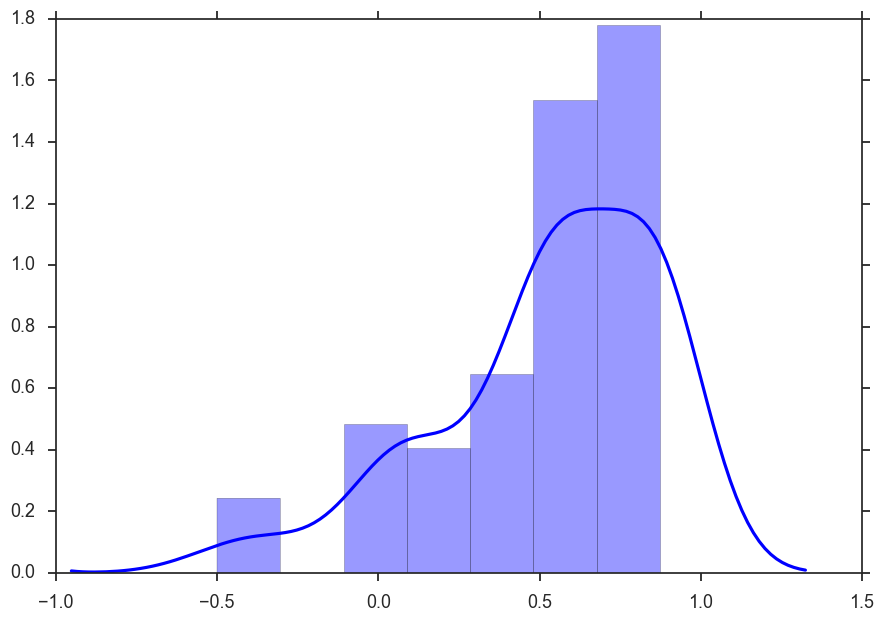

In [38]:
sns.distplot(BCF.scores_)

In [39]:
yy = BCF.all_preds_[:, BCF.features_idx_]
print(pearsonr(yy, y)[0]**2)
print(BCF.features_)

0.761842605823
['TEMP', 'RH', 'S_1']


In [40]:
xx = BCF.transform(to_model)
BCF.estimator_.score(xx, y)

BCF.score(to_model, y)

0.80493016425997888

0.804930209434


(-6.0, 6.0)

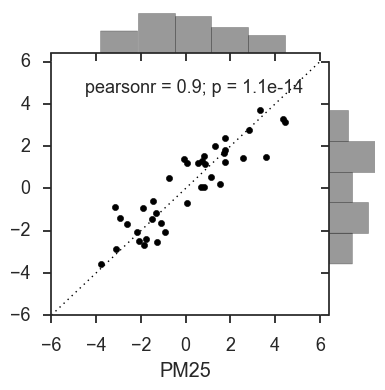

In [41]:
pred = BCF.predict(to_model)
print(pearsonr(y, pred)[0]**2)

jg = sns.jointplot(y, pred, size=4, color='k')
xlo, xhi = jg.ax_joint.get_xlim()
ylo, yhi = jg.ax_joint.get_ylim()
lo, hi = np.min([xlo, ylo]), np.max([xhi, yhi])
jg.ax_joint.plot([lo, hi], [lo, hi], color='k', lw=1., ls='dotted')
jg.ax_joint.set_xlim(lo, hi)
jg.ax_joint.set_ylim(lo, hi)

## `GridSearch` extension

Some final thoughts on this:

- An alternative way to write what ended up being our inner loop (selecting the features) could be accomplished with a `GridSearchCV`. We'd write our cross-validation wrapper, and add a step to our transformation pipeline before linear estimation which selects a set of predictors, say **select_predictors**. We would then pass the array of potential predictor combinations as an argument to `GridSearchCV`. Below, I'll implement this without the cross-validation step as an example.

  In actuality, we can't use `GridSearchCV` because that would require our pipeline to support top-level cross validation (which it doesn't because we index into Datasets differently than arrays). So instead we'll use a `ParameterGrid`.

In [41]:
pp = Pipeline([
    ('features', DatasetFeatureUnion([
        ('local', local_pipeline),
        ('hybrid', hybrid_pipeline),
    ])),
    ('select_predictors', FieldExtractor(fields=predictors)),
    ('dataset_to_array', DatasetAdapater(drop=['lat', 'lon'])),
    ('model', LinearRegression()),    
])

In [42]:
from air_quality.util import all_combos
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import ParameterGrid

ac = list(all_combos(predictors + ['S_1', 'S_2'], 3))
param_grid = dict(
    select_predictors__fields = ac
)

grid = ParameterGrid(param_grid)

/Users/daniel/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/daniel/anaconda/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [43]:
# scores = []
# for g in grid:
#     print(g)
#     pp.set_params(**g)
#     pp.fit(to_model, y)
#     score = pp.score(to_model, y)
#     scores.append(scores)

In [44]:
pp = DatasetFeatureUnion([
    ('local', local_pipeline),
    ('hybrid', hybrid_pipeline),
])
_X_pp = pp.fit_transform(to_model, y)

def make_pipeline(fields):
    return Pipeline([
        ('dataset_to_array', DatasetAdapater(fields=fields,
                                             drop=['lat', 'lon'])),
        ('model', LinearRegression()),    
    ])

scores = []
for fields in tqdm(ac):
    fields = list(fields)
    pp = make_pipeline(fields)
    pp.fit(_X_pp, y)
    score = pp.score(_X_pp, y)
    scores.append(score)
idx = np.argmax(scores)
best_score = scores[idx]
best_fields = ac[idx]
print(best_score, best_fields)

100%|██████████| 63/63 [00:00<00:00, 144.95it/s]

0.80493016426 ('TEMP', 'RH', 'S_1')


So as it turns out, there are **2** reasons that we can't use `GridSearchCV` with this workflow:

1. Again, our cross-validation method needs to operate on Datasets, which the default mechanisms aren't capable of doing unfortunately.

2. We can only set parameters on `Estimator`s - not on feature processing elements.

The latter point excludes our `ParameterGrid` solution too, since the `DatasetAdapter` and `FieldExtractor` transformers can't be updated with new parameters unless we add that functionality. But I don't think it's necessary; we're not really in complex territory here.

---

That should close out this exploration. We have everything we need to dramatically simplify the workflow in our `Shen2017` model.

# Evaluation

In [20]:
import xarray as xr
import numpy as np
from air_quality.models.shen2017_pipeline import Shen2017Model

grid_stack = ['lat', 'lon']
cell_name = 'cell'
predictand = 'PM25'
predictors = ['TEMP', 'RH', 'PRECIP', 'U', 'V']
dilon, dilat = 6, 4

data = xr.open_dataset("../data/obs.usa_subset.nc")

mask = np.isnan(data.PRECIP.isel(time=0)).rename("CONUS_MASK")

month = 6
model = Shen2017Model(
    data,
    month=month, verbose=True, n_predictors=3, hybrid=True,
    lat_range=(30, 35), lon_range=(-85, -80), 
    mask=mask
)

In [21]:
# model.fit_parallel(3)
model.fit()

Loop over all grid cells: 100%|██████████| 288/288 [00:35<00:00,  8.17it/s]  


In [22]:
_res = model.predict(data)

Iterate over grid cell models: 100%|██████████| 288/288 [00:00<00:00, 680.05it/s] 


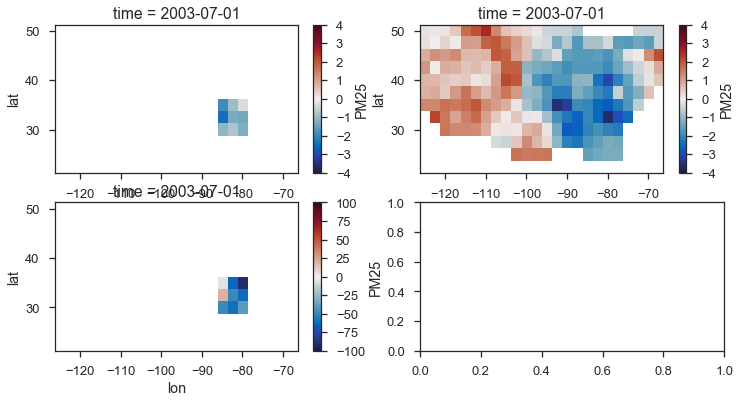

In [33]:
import cmocean
fig, axs = plt.subplots(2, 2, figsize=(12, 6))
axs = axs.ravel()

ti = 3*(5) -1
kwargs = dict(vmin=-4., vmax=4., cmap=cmocean.cm.balance)
_res.isel(time=ti)['PM25'].plot.imshow(ax=axs[0], **kwargs)
model.data.isel(time=ti)['PM25'].plot.imshow(ax=axs[1], **kwargs)
(100*(_res - model.data)/model.data).isel(time=ti)['PM25'].plot.imshow(
    ax=axs[2], vmin=-100, vmax=100, cmap=cmocean.cm.balance)


In [24]:
_rsq = _res.copy().isel(time=0)['PM25'] * np.nan
_rsq.name = 'r2'
_rsq_vals = _rsq.values

for gcr, gcf in model._gcr_gcf_iter:
    if gcr is None: continue
    _rsq[gcf.ilat, gcf.ilon] = gcr.score**2

Iterate over grid cell models: 100%|██████████| 288/288 [00:00<00:00, 452080.67it/s]


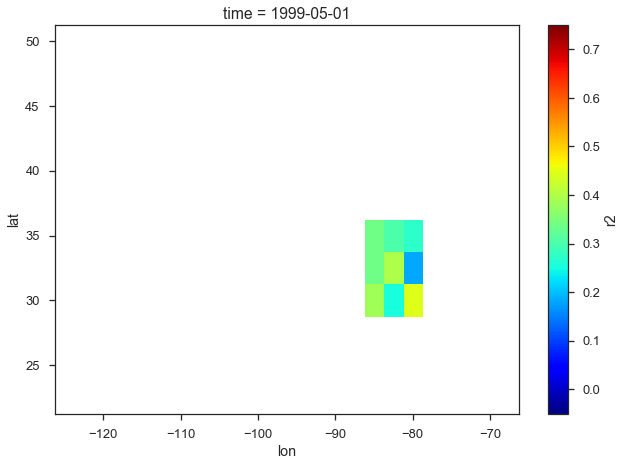

In [25]:
_rsq.plot.imshow(vmin=-0.05, vmax=0.75, cmap='jet')

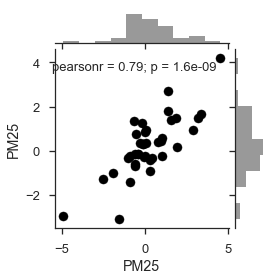

In [26]:
from air_quality.models.shen2017_pipeline import sites

site = sites['Georgia']
local_pred = _res.sel(lon=site.lon, lat=site.lat, method='nearest')
local = model.data.sel(lon=site.lon, lat=site.lat, method='nearest')

jg = sns.jointplot(local['PM25'], local_pred['PM25'],
                   color='k', size=4)

Iterate over grid cell models:   0%|          | 0/288 [00:00<?, ?it/s]


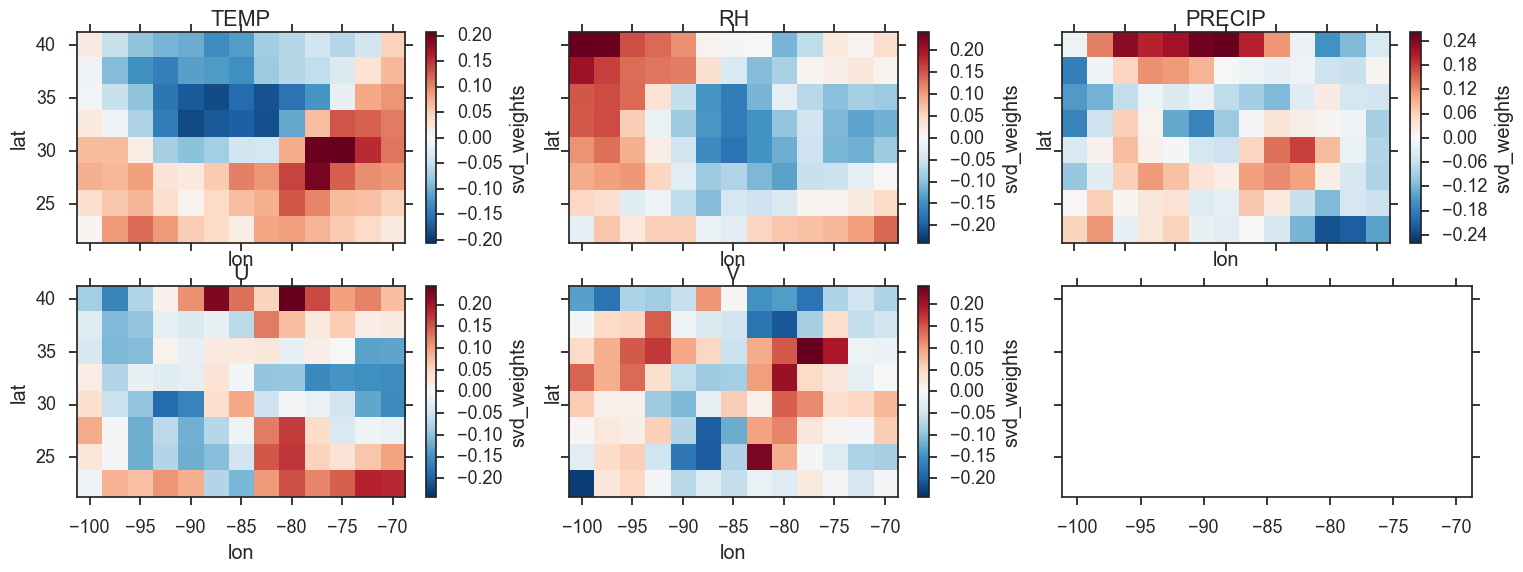

In [19]:
from air_quality.util import find_nearest

ilon = int(find_nearest(data.lon, site.lon))
ilat = int(find_nearest(data.lat, site.lat))

# Select the Georgia cell
for gcr, gcf in model._gcr_gcf_iter:
    if gcf is None: continue
    if (gcf.ilon == ilon) and (gcf.ilat == ilat):
        break

# Get the SVDModeCompressor for Georgia cell
fs = gcr.model.transformer_.named_steps['features']
transformers = {key: val for key, val in fs.transformer_list}
s = transformers['hybrid'].named_steps['svd_modes']

_sm = s.svd_modes_.unstack('cell')['svd_weights']
fig, axs = plt.subplots(2, 3, figsize=(18, 6),
                        sharex=True, sharey=True)
axs = axs.ravel()
for ((i, field), ax) in zip(enumerate(model.predictors), axs):
    _sm.isel(mode=i).plot.imshow('lon', 'lat', ax=ax)
    ax.set_title(field)
    
# ax.set_xlim(-125, -65)
# ax.set_ylim(20, 55)

In [14]:
_sm

<xarray.DataArray 'svd_weights' (mode: 5, lon: 13, lat: 8)>
array([[[ 0.00341 ,  0.035321, ..., -0.007094,  0.018681],
        [ 0.087989,  0.05569 , ..., -0.089236, -0.045485],
        ..., 
        [ 0.039998,  0.061235, ...,  0.0296  , -0.039702],
        [ 0.02053 ,  0.047809, ...,  0.067493,  0.047103]],

       [[-0.018993,  0.049392, ...,  0.204337,  0.241248],
        [ 0.066534,  0.039517, ...,  0.165423,  0.235698],
        ..., 
        [ 0.09879 ,  0.020921, ...,  0.027557,  0.008403],
        [ 0.138588,  0.046186, ...,  0.007855,  0.037783]],

       ..., 
       [[-0.011324,  0.030359, ..., -0.030907, -0.083477],
        [ 0.084429, -0.002365, ..., -0.107027, -0.160237],
        ..., 
        [ 0.186611,  0.068242, ...,  0.017991,  0.121329],
        [ 0.183964,  0.097165, ...,  0.022313,  0.073743]],

       [[-0.229264, -0.026828, ..., -0.003878, -0.13136 ],
        [ 0.027588,  0.045468, ...,  0.047597, -0.177439],
        ..., 
        [-0.040709, -0.076795, ..., -0.

In [94]:
fs = gcr.model.transformer_.named_steps['features']
transformers = {key: val for key, val in fs.transformer_list}
s = transformers['hybrid'].named_steps['svd_modes']

s

In [71]:
model.estimator.named_steps

{'dataset_to_array': <air_quality.sklearn.DatasetAdapter at 0x12816a438>,
 'linear': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)}